# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [65]:
# Importando as bibliotecas necessárias:
import pandas as pd
import zipfile
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

In [2]:
# Lendo o arquivo zip:
arquivo_zip = zipfile.ZipFile('dataset.zip')

# Definindo os meses que será utilizado para montar a base de dados:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

# Criando um loop que irá passar entrar no arquivo zip, lê cada arquivo csv, criar colunas de ano e mês de acordo com o nome, e armazenar o resultado de todos os 25 arquivos em apenas 1 dataframe: 
base_airbnb = pd.DataFrame()

for arquivo_nome in tqdm(arquivo_zip.namelist()):
    mes = meses[arquivo_nome[8:11]]
    ano = int(arquivo_nome[-8:-4])
    df = pd.read_csv(arquivo_zip.open(f'{arquivo_nome}'), low_memory=False)
    df['mes'] = mes
    df['ano'] = ano
    base_airbnb = pd.concat([base_airbnb, df])

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:14<00:00,  5.36s/it]


In [3]:
# Criando uma cópia do dataframe para podermos realizar os devidos tratamentos:
base_airbnb_rio = base_airbnb.copy()
base_airbnb_rio

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

### Identificar quais colunas podemos excluir

Uma análise rápida permite ver que várias colunas não são necessárias para o nosso estudo, por isso iremos exluir os seguintes tipos de colunas:

- IDs, Links e informações não relevantes para o modelo
- Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex: Data x Ano/Mês
- Colunas preenchidas com texto livre -> Não faremos nenhuma análise de palavras ou algo do tipo
- Colunas em que todos ou quase todos os valores são iguais ou nulos

In [4]:
print(list(base_airbnb_rio.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Após a análise qualitativa das colunas, nosso DataFrame ficou com as seguintes colunas: 

In [5]:
# Alterando o Dataframe, para manter apenas as colunas relevantes para nossas análises:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
base_airbnb_rio = base_airbnb_rio.loc[:, colunas]

base_airbnb_rio.isnull().sum()

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

### Tratar Valores Faltando

Para que as análises que iremos realizar, colunas com valores nulos irão atrapalhar ou até mesmo inviabilizar as análises. Para contornar isso iremos tratá-los:

In [6]:
# Realizando alteração nas colunas, para tratar os valores nulos: 
base_airbnb_rio['cleaning_fee'].fillna('$0.00', inplace=True)
base_airbnb_rio['security_deposit'].fillna('$0.00', inplace=True)
base_airbnb_rio['review_scores_rating'].fillna(0.0, inplace=True)
base_airbnb_rio['review_scores_accuracy'].fillna(0.0, inplace=True)
base_airbnb_rio['review_scores_cleanliness'].fillna(0.0, inplace=True)
base_airbnb_rio['review_scores_checkin'].fillna(0.0, inplace=True)
base_airbnb_rio['review_scores_communication'].fillna(0.0, inplace=True)
base_airbnb_rio['review_scores_location'].fillna(0.0, inplace=True)
base_airbnb_rio['review_scores_value'].fillna(0.0, inplace=True)
base_airbnb_rio['host_response_time'].fillna('never answered', inplace=True)
base_airbnb_rio['host_response_rate'].fillna('0%', inplace=True)

# Como temos agora poucas linhas com valores núlos, iremos retirar as linhas com valores núlos pois não serão relevantes para o modelo:
base_airbnb_rio = base_airbnb_rio.dropna()

base_airbnb_rio.isnull().sum()

host_response_time             0
host_response_rate             0
host_is_superhost              0
host_listings_count            0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
bed_type                       0
amenities                      0
price                          0
security_deposit               0
cleaning_fee                   0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
instant_bookable               0
is_busines

### Verificar Tipos de Dados em cada coluna

In [7]:
# análisando o tipo de cada coluna e printando o primeiro valor dessa coluna para auxiliar nas análises:
print(base_airbnb_rio.dtypes)
print('-'*60)
print(base_airbnb_rio.iloc[0])

host_response_time              object
host_response_rate              object
host_is_superhost               object
host_listings_count            float64
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
amenities                       object
price                           object
security_deposit                object
cleaning_fee                    object
guests_included                  int64
extra_people                    object
minimum_nights                   int64
maximum_nights                   int64
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin    

 - Como as colunas price, security_deposit, cleaning_fee, extra peaple e host_response_rate estão com os tipos divergente de seus real valores, precisamos tratar essas colunas para corrigirmos o seu tipo:

In [8]:
#tratando a coluna price 
base_airbnb_rio['price'] = base_airbnb_rio['price'].astype(str).str.replace('$', '')
base_airbnb_rio['price'] = base_airbnb_rio['price'].str.replace(',', '')
base_airbnb_rio['price'] = base_airbnb_rio['price'].astype(np.float32, copy=False)

#tratando a coluna security_deposit
base_airbnb_rio['security_deposit'] = base_airbnb_rio['security_deposit'].astype(str).str.replace('$', '')
base_airbnb_rio['security_deposit'] = base_airbnb_rio['security_deposit'].str.replace(',', '')
base_airbnb_rio['security_deposit'] = base_airbnb_rio['security_deposit'].astype(np.float32, copy=False)

#tratando a coluna cleaning_fee
base_airbnb_rio['cleaning_fee'] = base_airbnb_rio['cleaning_fee'].astype(str).str.replace('$', '')
base_airbnb_rio['cleaning_fee'] = base_airbnb_rio['cleaning_fee'].str.replace(',', '')
base_airbnb_rio['cleaning_fee'] = base_airbnb_rio['cleaning_fee'].astype(np.float32, copy=False)

#tratando a coluna extra peaple
base_airbnb_rio['extra_people'] = base_airbnb_rio['extra_people'].astype(str).str.replace('$', '')
base_airbnb_rio['extra_people'] = base_airbnb_rio['extra_people'].str.replace(',', '')
base_airbnb_rio['extra_people'] = base_airbnb_rio['extra_people'].astype(np.float32, copy=False)

#tratando a coluna host_response_rate
base_airbnb_rio['host_response_rate'] = base_airbnb_rio['host_response_rate'].astype(str).str.replace('%', '')
base_airbnb_rio['host_response_rate'] = base_airbnb_rio['host_response_rate'].astype(np.float32, copy=False)

print(base_airbnb_rio.dtypes)

C:\Users\Wanderson\AppData\Local\Temp\ipykernel_9624\3533400903.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb_rio['price'] = base_airbnb_rio['price'].astype(str).str.replace('$', '')
C:\Users\Wanderson\AppData\Local\Temp\ipykernel_9624\3533400903.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb_rio['security_deposit'] = base_airbnb_rio['security_deposit'].astype(str).str.replace('$', '')
C:\Users\Wanderson\AppData\Local\Temp\ipykernel_9624\3533400903.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when

host_response_time              object
host_response_rate             float32
host_is_superhost               object
host_listings_count            float64
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
amenities                       object
price                          float32
security_deposit               float32
cleaning_fee                   float32
guests_included                  int64
extra_people                   float32
minimum_nights                   int64
maximum_nights                   int64
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin    

 - Para ganharmos performance em nosso modelo, iremos alterar todos os tipos float64 e int64 para float32 e int32 respectivamente. Com isso teremos um modelo mais leve e performático. 

In [9]:
# Alterando os tipos das colunas para ganho de performance:
base_airbnb_rio['host_listings_count'] = base_airbnb_rio['host_listings_count'].astype(np.float32, copy=False)
base_airbnb_rio['latitude'] = base_airbnb_rio['latitude'].astype(np.float32, copy=False)
base_airbnb_rio['longitude'] = base_airbnb_rio['longitude'].astype(np.float32, copy=False)
base_airbnb_rio['accommodates'] = base_airbnb_rio['accommodates'].astype(np.int32, copy=False)
base_airbnb_rio['bathrooms'] = base_airbnb_rio['bathrooms'].astype(np.float32, copy=False)
base_airbnb_rio['bedrooms'] = base_airbnb_rio['bedrooms'].astype(np.float32, copy=False)
base_airbnb_rio['beds'] = base_airbnb_rio['beds'].astype(np.float32, copy=False)
base_airbnb_rio['guests_included'] = base_airbnb_rio['guests_included'].astype(np.int32, copy=False)
base_airbnb_rio['minimum_nights'] = base_airbnb_rio['minimum_nights'].astype(np.int32, copy=False)
base_airbnb_rio['maximum_nights'] = base_airbnb_rio['maximum_nights'].astype(np.int32, copy=False)
base_airbnb_rio['number_of_reviews'] = base_airbnb_rio['number_of_reviews'].astype(np.int32, copy=False)
base_airbnb_rio['review_scores_rating'] = base_airbnb_rio['review_scores_rating'].astype(np.float32, copy=False)
base_airbnb_rio['review_scores_accuracy'] = base_airbnb_rio['review_scores_accuracy'].astype(np.float32, copy=False)
base_airbnb_rio['review_scores_cleanliness'] = base_airbnb_rio['review_scores_cleanliness'].astype(np.float32, copy=False)
base_airbnb_rio['review_scores_checkin'] = base_airbnb_rio['review_scores_checkin'].astype(np.float32, copy=False)
base_airbnb_rio['review_scores_communication'] = base_airbnb_rio['review_scores_communication'].astype(np.float32, copy=False)
base_airbnb_rio['review_scores_location'] = base_airbnb_rio['review_scores_location'].astype(np.float32, copy=False)
base_airbnb_rio['review_scores_value'] = base_airbnb_rio['review_scores_value'].astype(np.float32, copy=False)
base_airbnb_rio['ano'] = base_airbnb_rio['ano'].astype(np.int32, copy=False)
base_airbnb_rio['mes'] = base_airbnb_rio['mes'].astype(np.int32, copy=False)

print(base_airbnb_rio.dtypes)

host_response_time              object
host_response_rate             float32
host_is_superhost               object
host_listings_count            float32
latitude                       float32
longitude                      float32
property_type                   object
room_type                       object
accommodates                     int32
bathrooms                      float32
bedrooms                       float32
beds                           float32
bed_type                        object
amenities                       object
price                          float32
security_deposit               float32
cleaning_fee                   float32
guests_included                  int32
extra_people                   float32
minimum_nights                   int32
maximum_nights                   int32
number_of_reviews                int32
review_scores_rating           float32
review_scores_accuracy         float32
review_scores_cleanliness      float32
review_scores_checkin    

## Análise Exploratória e Tratar Outliers

- É realizado agora uma análise esploraria de todas as colunas para identificarmos Outliers e quais colunas fazem sentido mantermos para a nossa análise ou não.

<AxesSubplot:>

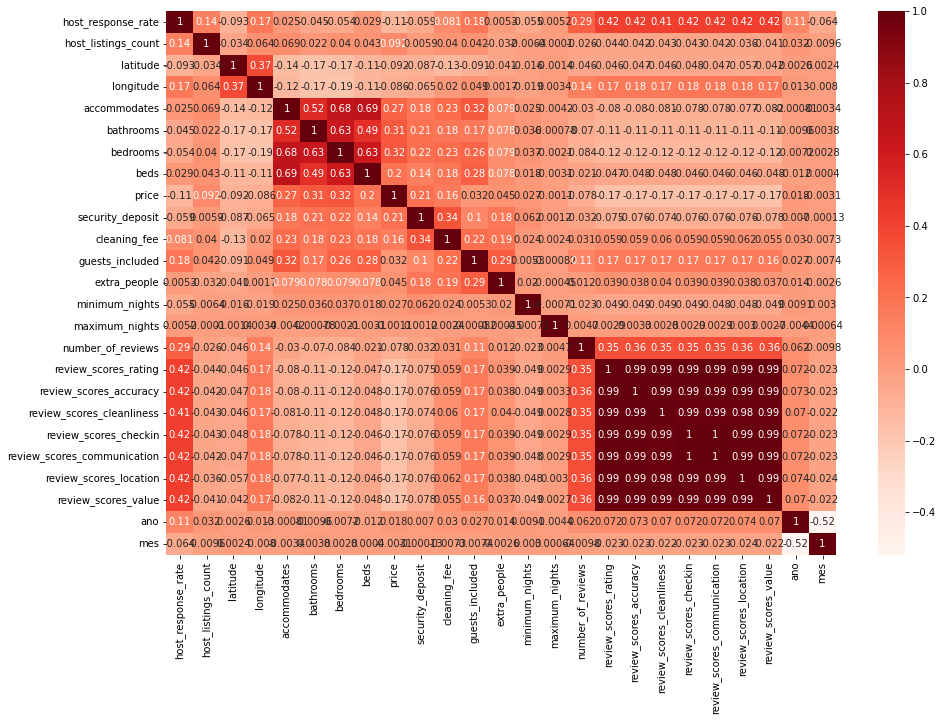

In [10]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb_rio.corr(), annot=True, cmap='Reds')

### Definição de Funções para Análise de Outliers
 - É definido algumas funçoes para auxiliar na análise de Outliers das colunas. 

In [11]:
# Função que irá qualcular o quanrtiu 1, quartiu 3, amplitude e definir os valores limites:
# Todos os valores acima ou abaixo dos limites podem ser Outliers.
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
, color='Reds'
# Função que irá excluir os outliers do nosso modelo, caso seja necessário:
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas 

# Função para realizar o plot dos gráficos tipo boxplot:
def plot_boxplot(coluna):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    
# Função para realizar o plot dos gráficos tipo histograma:
def plot_histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.distplot(coluna, hist=True)
    
# Função para realizar o plot dos gráficos tipo barra:
def plot_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Análisando a coluna "price"

C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


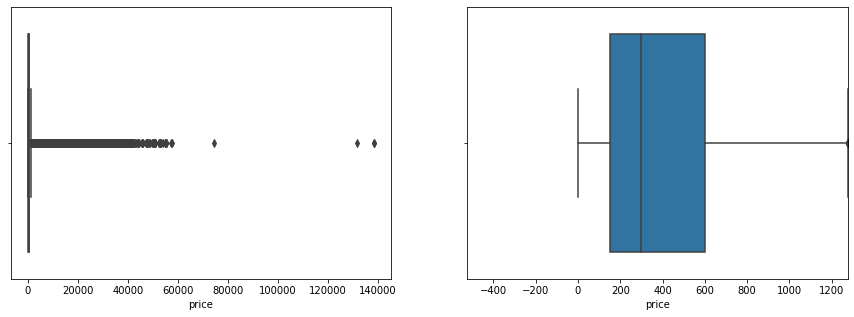

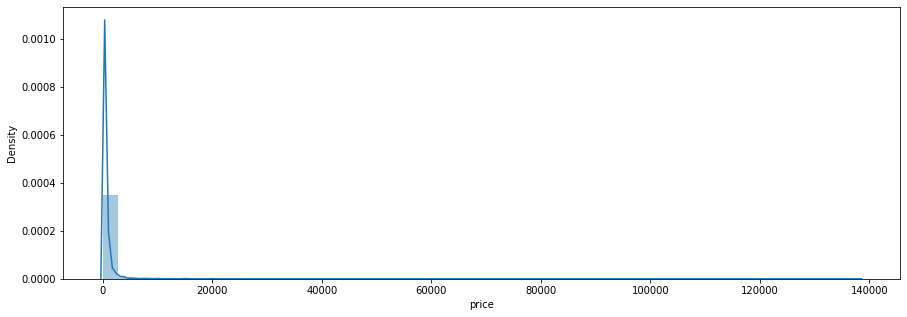

In [12]:
plot_boxplot(base_airbnb_rio['price'])
plot_histograma(base_airbnb_rio['price'])

Como estamos contruindo um modelo para imóveis comuns, os valores que estão acima do limite superior provavelmente são apartamentos de altíssimo luxo e não irão agregar para o objetivo do nosso modelo. Por isso, será exluido os outliers.

In [13]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'price')
print(f'{linhas_removidas} linhas foram removidas')

87282 linhas foram removidas


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


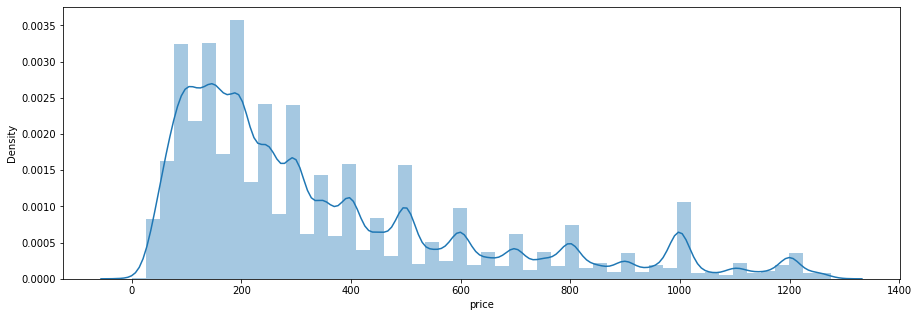

In [14]:
plot_histograma(base_airbnb_rio['price'])

### Análisando a coluna "extra_people"

C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


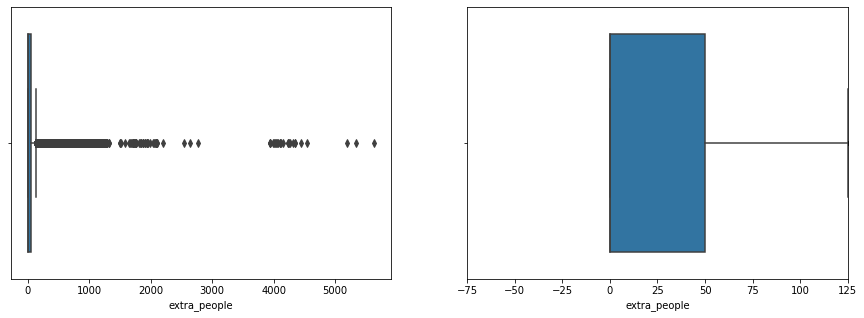

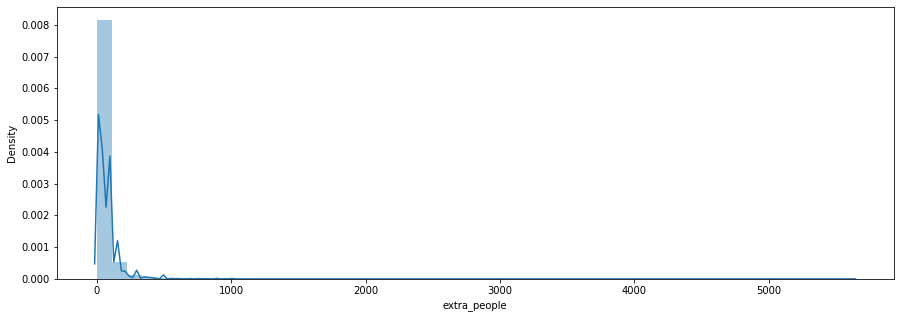

In [15]:
plot_boxplot(base_airbnb_rio['extra_people'])
plot_histograma(base_airbnb_rio['extra_people'])

In [16]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'extra_people')
print(f'{linhas_removidas} linhas foram removidas')

59194 linhas foram removidas


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


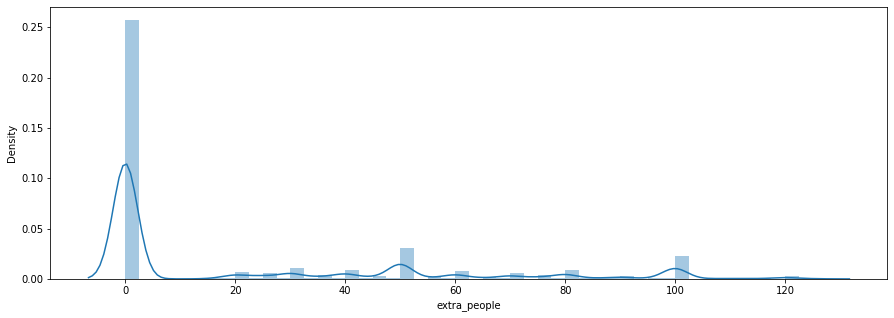

In [17]:
plot_histograma(base_airbnb_rio['extra_people'])

### Análisando a coluna "cleaning_fee"

C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


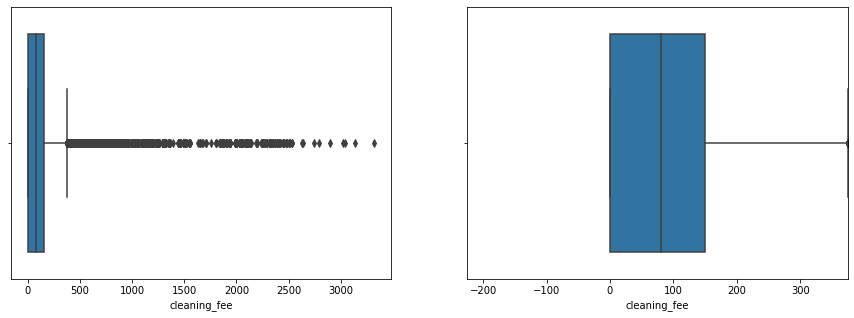

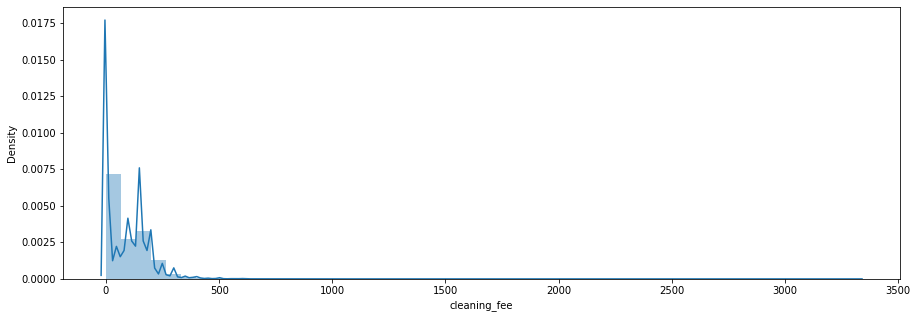

In [18]:
plot_boxplot(base_airbnb_rio['cleaning_fee'])
plot_histograma(base_airbnb_rio['cleaning_fee'])

In [19]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'cleaning_fee')
print(f'{linhas_removidas} linhas foram removidas')

9909 linhas foram removidas


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


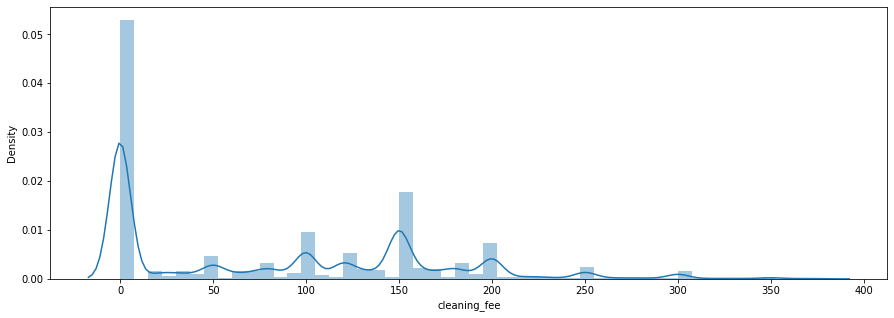

In [20]:
plot_histograma(base_airbnb_rio['cleaning_fee'])

### Análisando a coluna "security_deposit"

C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


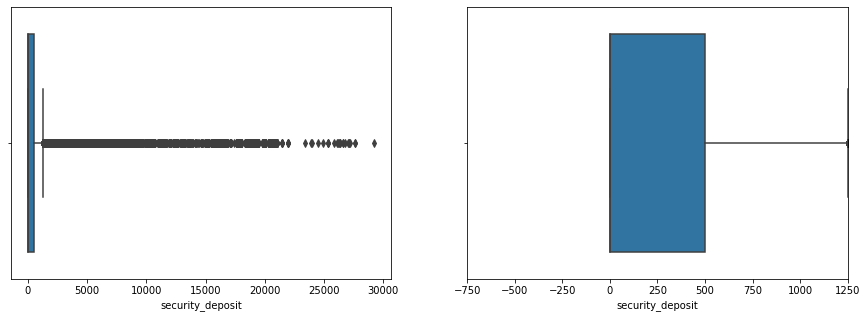

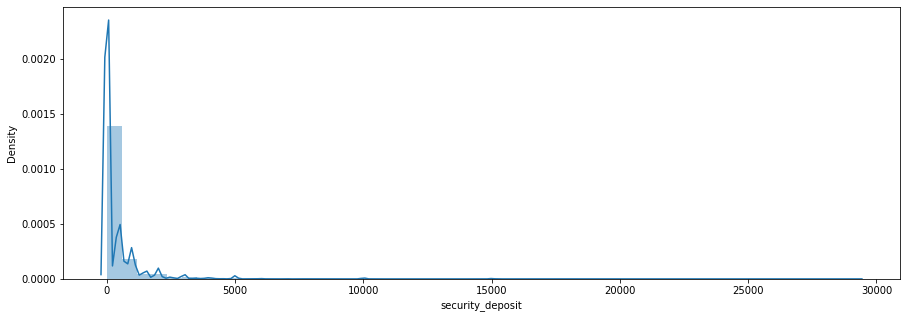

In [21]:
plot_boxplot(base_airbnb_rio['security_deposit'])
plot_histograma(base_airbnb_rio['security_deposit'])

In [22]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'security_deposit')
print(f'{linhas_removidas} linhas foram removidas')

58115 linhas foram removidas


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


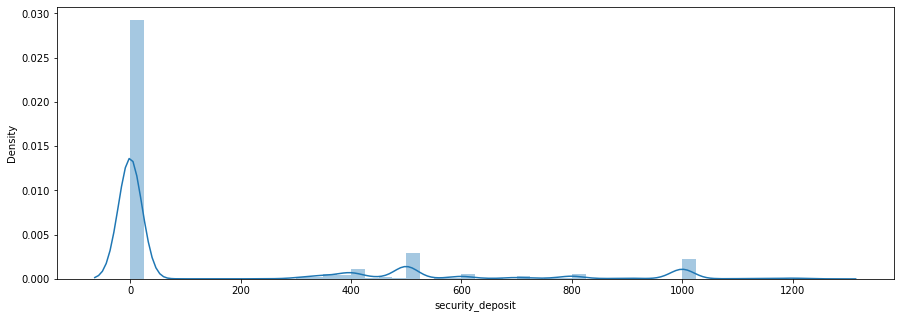

In [23]:
plot_histograma(base_airbnb_rio['security_deposit'])

### Análisando a coluna "host_listings_count"

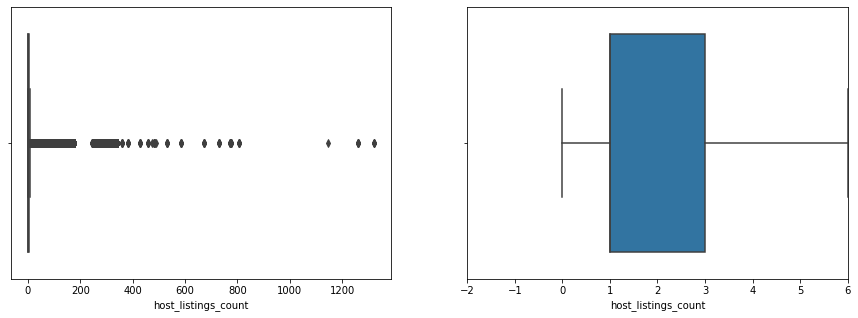

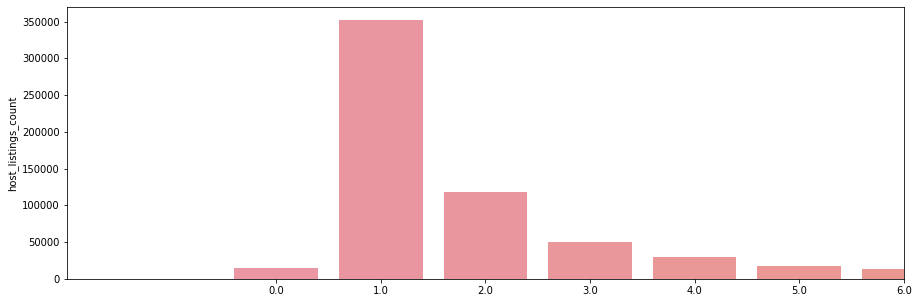

In [24]:
plot_boxplot(base_airbnb_rio['host_listings_count'])
plot_barra(base_airbnb_rio['host_listings_count'])

Como hosts com mais de 6 imóveis foge do nosso objetivo de estudo, iremos excluir os outliers a fim de mantermos a base de dados direcionada ao objetivo principal.

In [25]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'host_listings_count')
print(f'{linhas_removidas} linhas foram removidas')

88562 linhas foram removidas


### Análisando a coluna "accommodates"

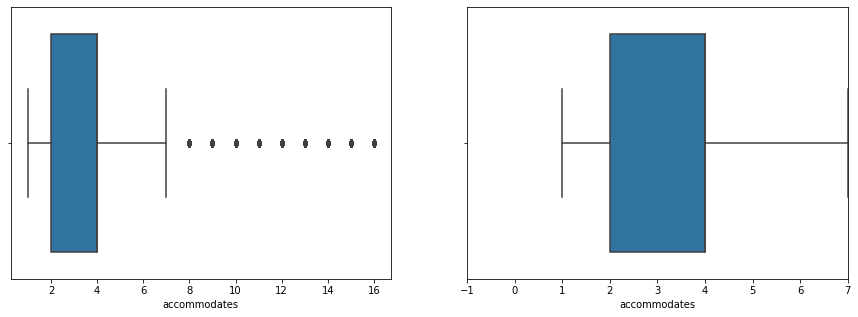

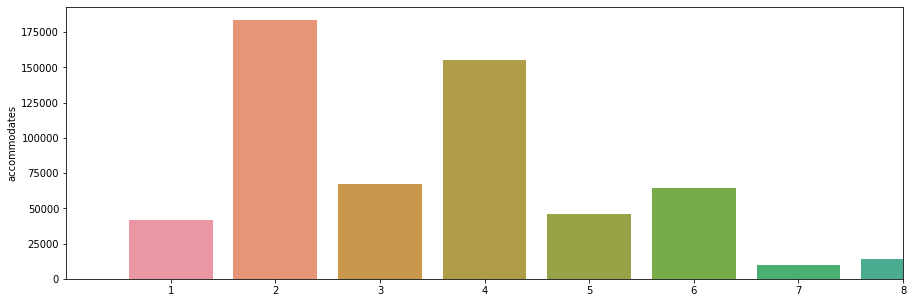

In [26]:
plot_boxplot(base_airbnb_rio['accommodates'])
plot_barra(base_airbnb_rio['accommodates'])

In [27]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'accommodates')
print(f'{linhas_removidas} linhas foram removidas')

27111 linhas foram removidas


### Análisando a coluna "bathrooms"

<AxesSubplot:ylabel='bathrooms'>

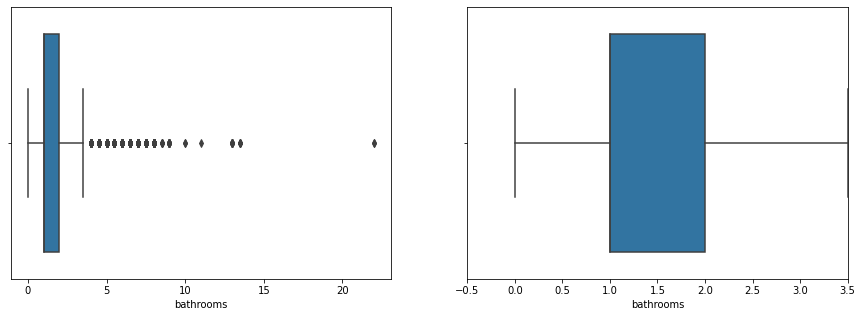

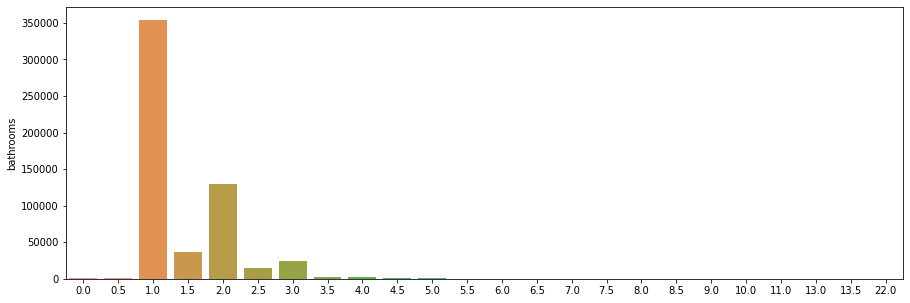

In [28]:
plot_boxplot(base_airbnb_rio['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb_rio['bathrooms'].value_counts().index, y=base_airbnb_rio['bathrooms'].value_counts())

In [29]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'bathrooms')
print(f'{linhas_removidas} linhas foram removidas')

3836 linhas foram removidas


### Análisando a coluna "bedrooms"

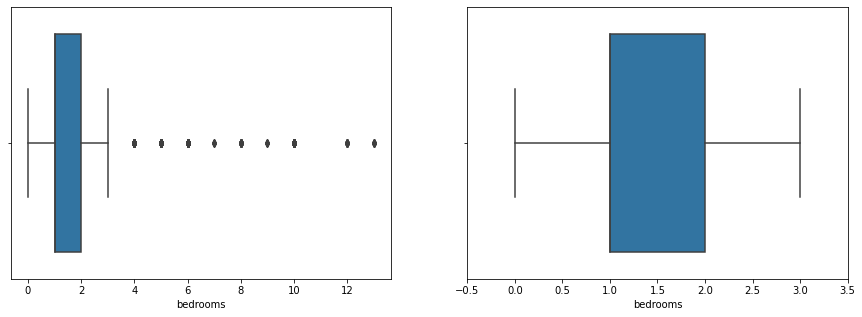

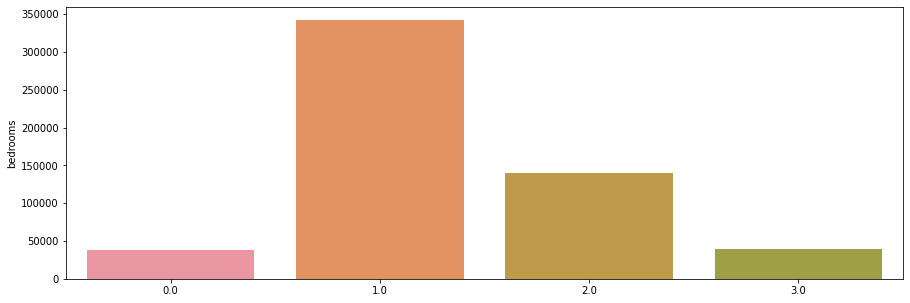

In [30]:
plot_boxplot(base_airbnb_rio['bedrooms'])
plot_barra(base_airbnb_rio['bedrooms'])

In [31]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'bedrooms')
print(f'{linhas_removidas} linhas foram removidas')

2246 linhas foram removidas


### Análisando a coluna "beds"

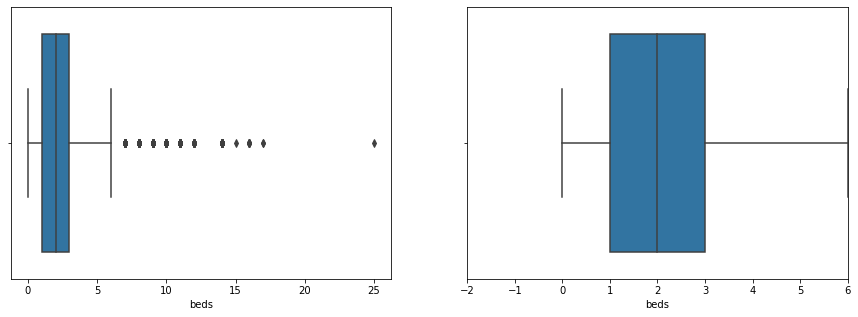

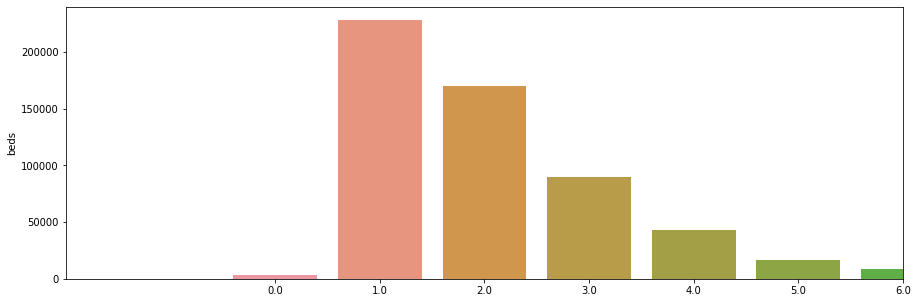

In [32]:
plot_boxplot(base_airbnb_rio['beds'])
plot_barra(base_airbnb_rio['beds'])

In [33]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'beds')
print(f'{linhas_removidas} linhas foram removidas')

2038 linhas foram removidas


### Análisando a coluna "guests_included"

C:\Users\Wanderson\AppData\Local\Temp\ipykernel_9624\2882134067.py:22: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\Wanderson\AppData\Local\Temp\ipykernel_9624\2882134067.py:34: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(limites(coluna))


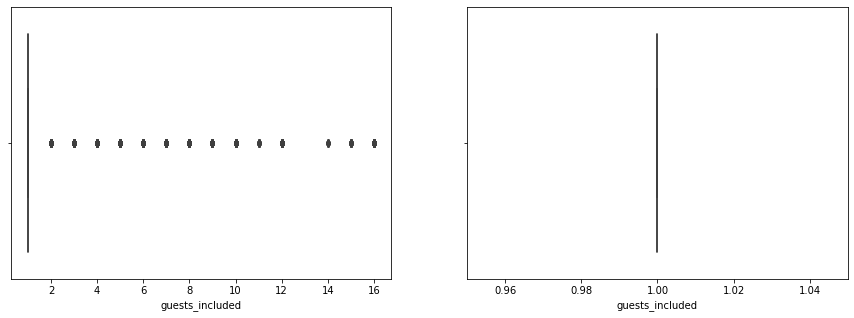

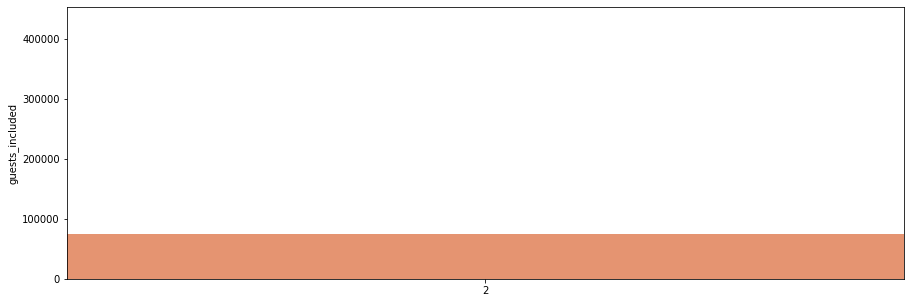

In [34]:
plot_boxplot(base_airbnb_rio['guests_included'])
plot_barra(base_airbnb_rio['guests_included'])

Vamos remover essa feature da análise. A maior parte dos valores é preenchida de forma padrão como 1 guest included, o que torna essa feature não essencial para a definição do preço. Sendo assim iremos excluir essa coluna da análise.

In [35]:
base_airbnb_rio = base_airbnb_rio.drop('guests_included', axis=1)
base_airbnb_rio.shape

(559416, 33)

### Análisando a coluna "minimum_nights"

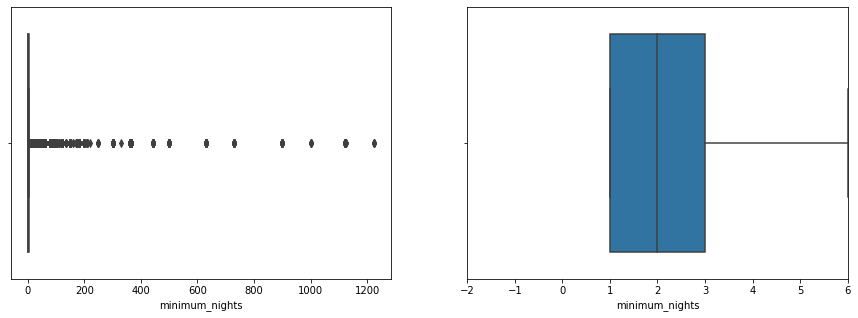

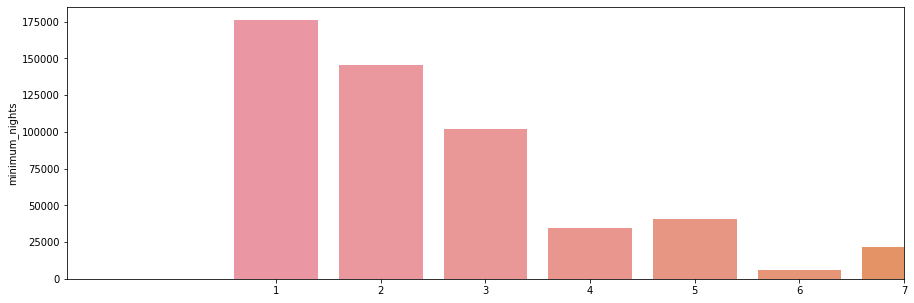

In [36]:
plot_boxplot(base_airbnb_rio['minimum_nights'])
plot_barra(base_airbnb_rio['minimum_nights'])

In [37]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'minimum_nights')
print(f'{linhas_removidas} linhas foram removidas')

54256 linhas foram removidas


### Análisando a coluna "maximum_nights"

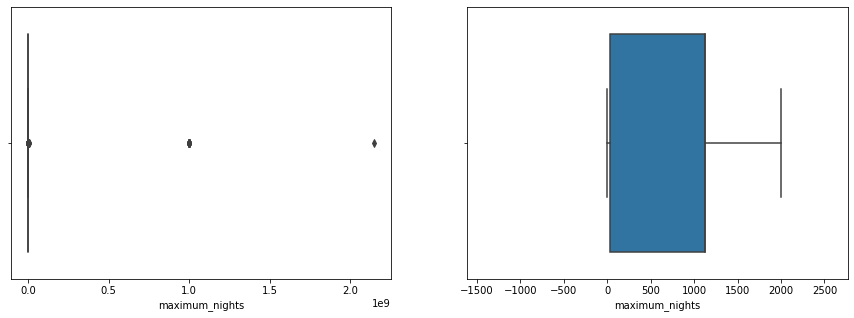

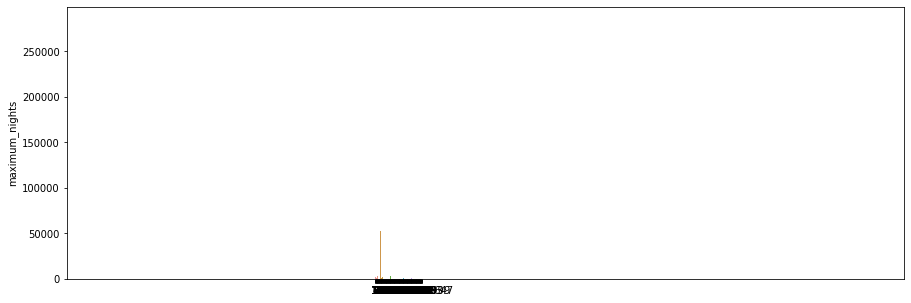

In [38]:
plot_boxplot(base_airbnb_rio['maximum_nights'])
plot_barra(base_airbnb_rio['maximum_nights'])

Iremos retirar essa coluna da análise pois não será relevante considerarmos o máximo de noites para o objetivo do modelo.

In [39]:
base_airbnb_rio = base_airbnb_rio.drop('maximum_nights', axis=1)
base_airbnb_rio.shape

(505160, 32)

### Análisando a coluna "number_of_reviews"

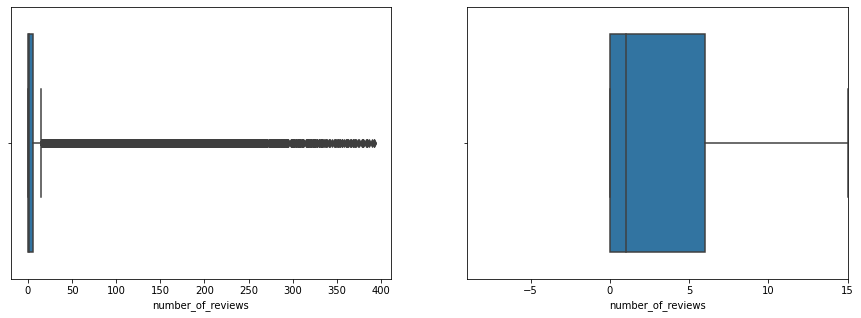

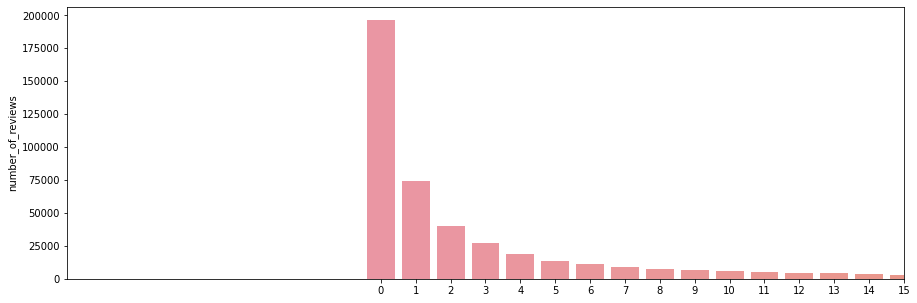

In [40]:
plot_boxplot(base_airbnb_rio['number_of_reviews'])
plot_barra(base_airbnb_rio['number_of_reviews'])

Não iremos remover os outliers do modelo pois corre-se o risco de remover hosts importantes para a nossa análise, que estão fazendo um bom trabalho junto ao airbnb.

## Tratamento de Colunas de Valores de Texto

### Análisando a coluna "property_type"

Apartment                 394356
House                      46465
Condominium                22814
Serviced apartment         11187
Loft                       11140
Guest suite                 3491
Bed and breakfast           3383
Hostel                      2507
Guesthouse                  1898
Other                       1668
Villa                       1202
Townhouse                    855
Aparthotel                   563
Chalet                       476
Boutique hotel               447
Earth house                  436
Tiny house                   421
Hotel                        356
Casa particular (Cuba)       258
Cottage                      188
Bungalow                     185
Dorm                         173
Nature lodge                 120
Cabin                        115
Castle                        80
Island                        54
Treehouse                     51
Hut                           40
Campsite                      34
Resort                        31
Camper/RV 

C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


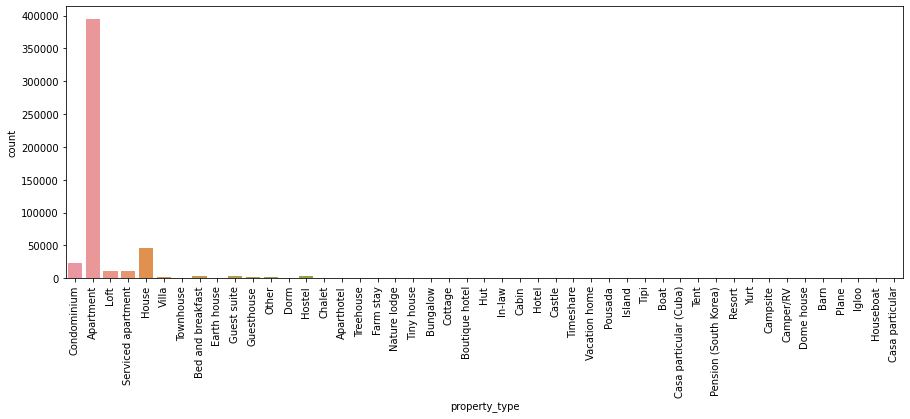

In [41]:
print(base_airbnb_rio['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb_rio)
grafico.tick_params(axis='x', rotation=90)

['Guesthouse', 'Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Boutique hotel', 'Earth house', 'Tiny house', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Nature lodge', 'Cabin', 'Castle', 'Island', 'Treehouse', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Boat', 'Tent', 'Tipi', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Barn', 'Vacation home', 'Houseboat', 'Timeshare', 'Pousada', 'Casa particular', 'Plane']
Apartment             394356
House                  46465
Condominium            22814
Serviced apartment     11187
Loft                   11140
Outros                  9817
Guest suite             3491
Bed and breakfast       3383
Hostel                  2507
Name: property_type, dtype: int64


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


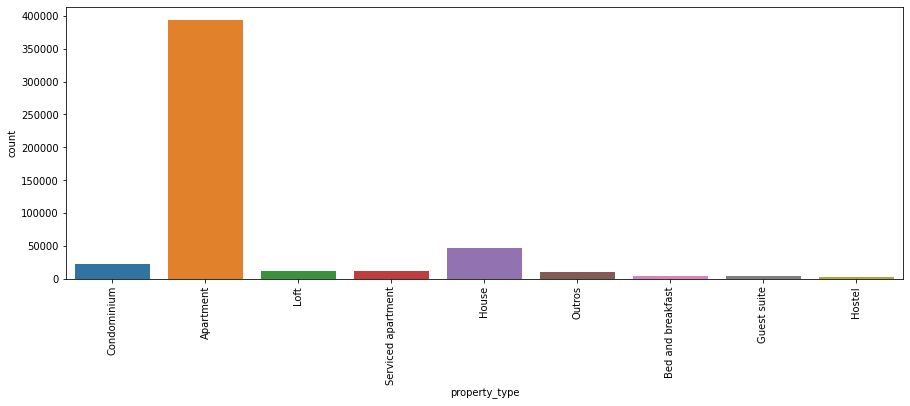

In [42]:
tabela_tipos_casa = base_airbnb_rio['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_rio.loc[base_airbnb_rio['property_type']==tipo, 'property_type'] = 'Outros'
    
print(base_airbnb_rio['property_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('property_type', data=base_airbnb_rio)
grafico.tick_params(axis='x', rotation=90)

### Análisando a coluna "room_type"

Entire home/apt    308099
Private room       185213
Shared room         10901
Hotel room            947
Name: room_type, dtype: int64


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


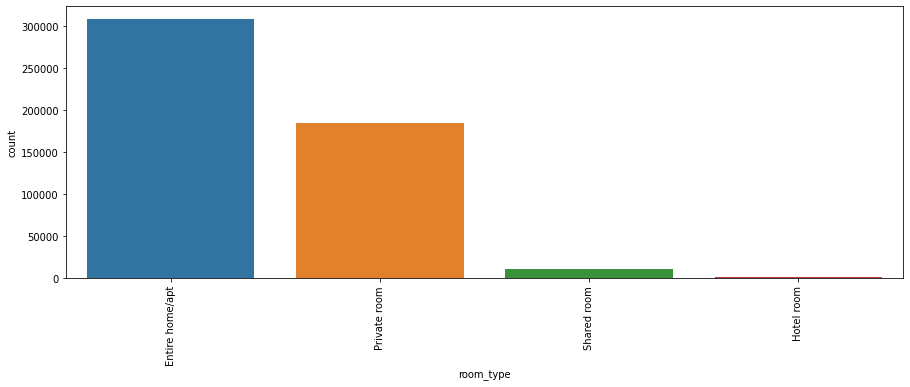

In [43]:
print(base_airbnb_rio['room_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('room_type', data=base_airbnb_rio)
grafico.tick_params(axis='x', rotation=90)

### Análisando a coluna "bed_type"

Real Bed         494974
Pull-out Sofa      7388
Futon              1537
Airbed              909
Couch               352
Name: bed_type, dtype: int64


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


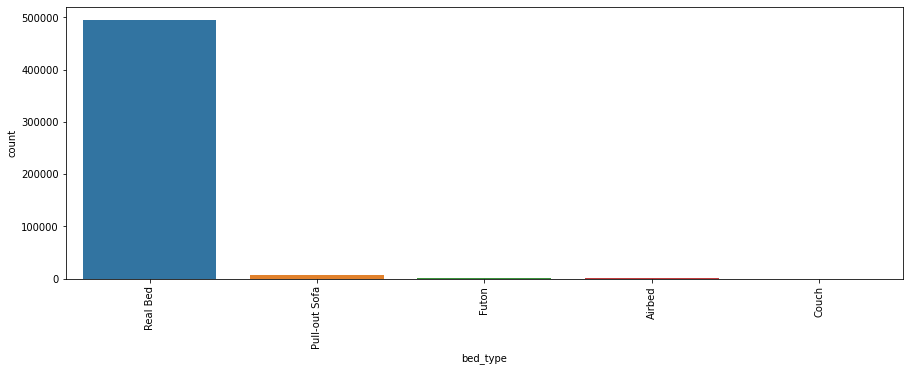

In [44]:
print(base_airbnb_rio['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airbnb_rio)
grafico.tick_params(axis='x', rotation=90)

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    494974
Outros       10186
Name: bed_type, dtype: int64


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


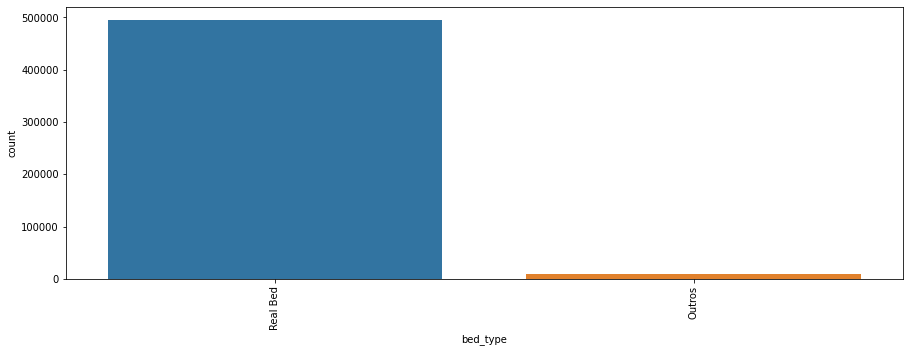

In [45]:
tabela_tipos_cama = base_airbnb_rio['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_rio.loc[base_airbnb_rio['bed_type']==tipo, 'bed_type'] = 'Outros'
    
print(base_airbnb_rio['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('bed_type', data=base_airbnb_rio)
grafico.tick_params(axis='x', rotation=90)

### Análisando a coluna "amenities"

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [46]:
# Criando uma coluna com a quantidade de amenities:
base_airbnb_rio['n_amenities'] = base_airbnb_rio['amenities'].str.split(',').apply(len)

# Deletando a coluna com a descrição dos amenities:
base_airbnb_rio = base_airbnb_rio.drop('amenities', axis=1)
base_airbnb_rio.shape

(505160, 32)

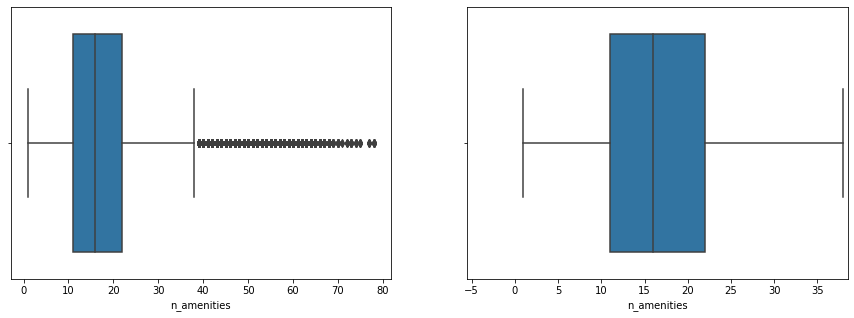

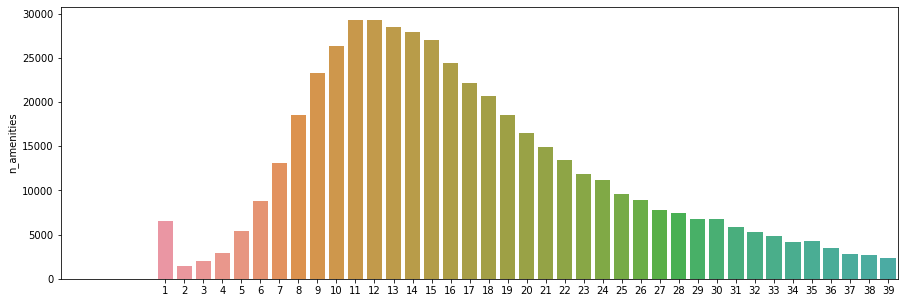

In [47]:
plot_boxplot(base_airbnb_rio['n_amenities'])
plot_barra(base_airbnb_rio['n_amenities'])

In [48]:
base_airbnb_rio, linhas_removidas = excluir_outliers(base_airbnb_rio, 'n_amenities')
print(f'{linhas_removidas} linhas foram removidas')

20633 linhas foram removidas


### Análisando a coluna "cancellation_policy"

flexible                       225923
strict_14_with_grace_period    157635
moderate                        92990
strict                           7837
super_strict_60                   114
super_strict_30                    28
Name: cancellation_policy, dtype: int64


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


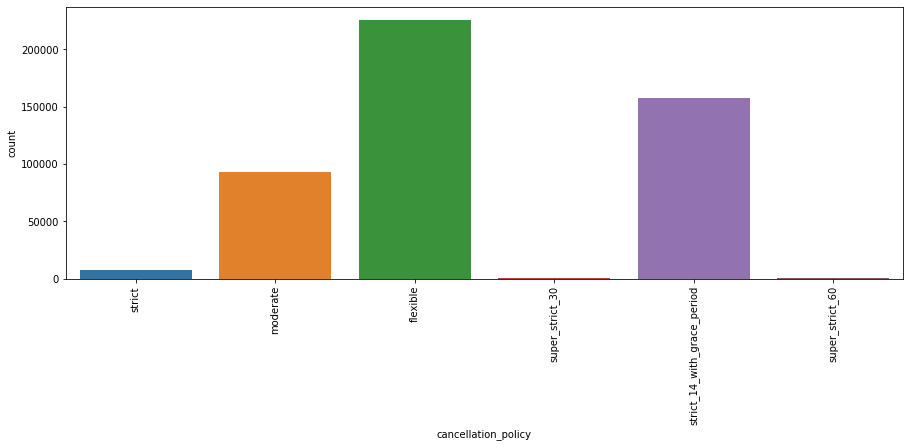

In [49]:
print(base_airbnb_rio['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb_rio)
grafico.tick_params(axis='x', rotation=90)

['strict', 'super_strict_60', 'super_strict_30']
flexible                       225923
strict_14_with_grace_period    157635
moderate                        92990
strict                           7979
Name: cancellation_policy, dtype: int64


C:\Users\Wanderson\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


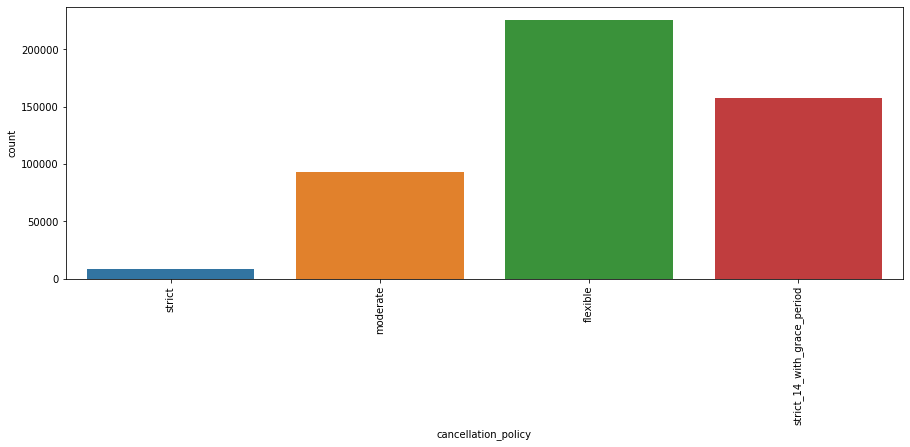

In [50]:
tabela_cancellation = base_airbnb_rio['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb_rio.loc[base_airbnb_rio['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'
    
print(base_airbnb_rio['cancellation_policy'].value_counts())

plt.figure(figsize=(15,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb_rio)
grafico.tick_params(axis='x', rotation=90)

## Visualização de Mapa das Propriedades

In [51]:
amostra = base_airbnb_rio.sample(n=35000)
centro_mapa = {'lat': amostra.latitude.mean(), 'lon': amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding

Ajustaremos as features para facilitar o trabalho do modelo de previsão.
 - Features de valores True ou False, serão alterados para 1 ou 0.
 - Features de Categorias, será utilziado o método de enconding de variáveis dummies.

In [52]:
# alterando as colunas True e False para 1 e 0:
colunas_tf =['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb_rio.copy()

for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [53]:
# codificando as colunas de categorias:
colunas_categorias = ['host_response_time', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())


host_response_rate host_is_superhost  host_listings_count   latitude  \
1               100.0                 1                  2.0 -22.965919   
3               100.0                 0                  3.0 -22.977118   
4               100.0                 1                  1.0 -22.983025   
5               100.0                 1                  1.0 -22.988165   
6               100.0                 1                  1.0 -22.981270   

   longitude  accommodates  bathrooms  bedrooms  beds  price  ...  \
1 -43.178963             5        1.0       2.0   2.0  270.0  ...   
3 -43.190453             3        1.0       1.0   2.0  161.0  ...   
4 -43.214272             3        1.0       1.0   2.0  222.0  ...   
5 -43.193588             3        1.5       1.0   2.0  308.0  ...   
6 -43.190456             2        1.0       1.0   2.0  219.0  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
1                          1                     0                       0   
3                          1                     0                       0   
4                          1                     0                       0   
5                          1                     0                       0   
6                          1                     0                       0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 51 columns]

In [54]:
# ajustando os tipos das colunas:
base_airbnb_cod['host_is_superhost'] = base_airbnb_cod['host_is_superhost'].astype(np.int32, copy=False)
base_airbnb_cod['instant_bookable'] = base_airbnb_cod['instant_bookable'].astype(np.int32, copy=False)
base_airbnb_cod['is_business_travel_ready'] = base_airbnb_cod['is_business_travel_ready'].astype(np.int32, copy=False)
base_airbnb_cod['n_amenities'] = base_airbnb_cod['n_amenities'].astype(np.int32, copy=False)

print(base_airbnb_cod.dtypes)
print('-'*60)
print(base_airbnb_cod.iloc[0])

host_response_rate                                 float32
host_is_superhost                                    int32
host_listings_count                                float32
latitude                                           float32
longitude                                          float32
accommodates                                         int32
bathrooms                                          float32
bedrooms                                           float32
beds                                               float32
price                                              float32
security_deposit                                   float32
cleaning_fee                                       float32
extra_people                                       float32
minimum_nights                                       int32
number_of_reviews                                    int32
review_scores_rating                               float32
review_scores_accuracy                             float

### Modelo de Previsão

- Métricas de Avaliação

In [81]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree

In [82]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Separação os dados em treino e teste + Treino do Modelo

In [84]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:95.32%
RSME:53.37
Modelo LinearRegression:
R²:37.62%
RSME:194.83
Modelo ExtraTrees:
R²:95.49%
RSME:52.41


### Análise do Melhor Modelo

- Melhor Modelo: ExtraTreessRegressor
    
    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTress.
    
    O modelo de regressão linear, apesar de ter uma excelente performance, não conseguiu obter resultados satisfatórios, com valores de R² e RSME piores que os demais modelos. 

### Ajustes e Melhorias no Melhor Modelo

0
bedrooms                                         0.110023
latitude                                         0.075739
longitude                                        0.064244
room_type_Entire home/apt                        0.059162
accommodates                                     0.057977
bathrooms                                        0.055480
n_amenities                                      0.052190
extra_people                                     0.051377
minimum_nights                                   0.042321
cleaning_fee                                     0.039248
beds                                             0.035528
review_scores_checkin                            0.034725
host_listings_count                              0.026273
host_response_time_never answered                0.023258
security_deposit                                 0.022419
host_response_rate                               0.020559
review_scores_value                              0.020273
number_of_reviews                                0.018699
instant_bookable                                 0.018647
review_scores_communication                      0.018255
review_scores_rating                             0.014944
cancellation_policy_flexible                     0.014389
review_scores_cleanliness                        0.013693
review_scores_location                           0.012153
property_type_Apartment                          0.011324
cancellation_policy_moderate                     0.011122
cancellation_policy_strict_14_with_grace_period  0.009864
ano                                              0.009676
review_scores_accuracy                           0.009201
property_type_House                              0.007023
mes                                              0.004821
room_type_Private room                           0.004501
property_type_Condominium                        0.003992
host_is_superhost                                0.002686
property_type_Outros                             0.002600
host_response_time_within an hour                0.002189
property_type_Serviced apartment                 0.002169
bed_type_Outros                                  0.002090
bed_type_Real Bed                                0.002089
room_type_Shared room                            0.001977
host_response_time_within a day                  0.001894
property_type_Bed and breakfast                  0.001746
host_response_time_a few days or more            0.001734
property_type_Loft                               0.001726
host_response_time_within a few hours            0.001295
cancellation_policy_strict                       0.000981
property_type_Guest suite                        0.000697
property_type_Hostel                             0.000543
room_type_Hotel room                             0.000489
is_business_travel_ready                         0.000000

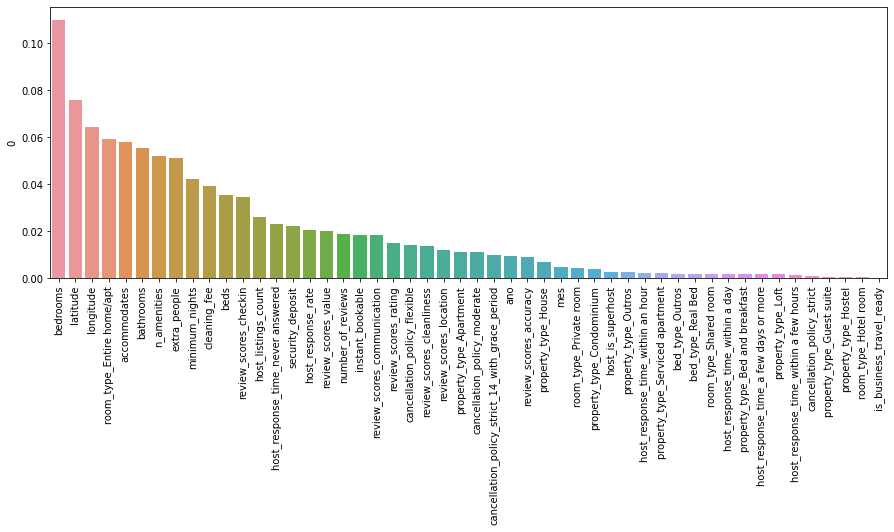

In [87]:
importancia_features = pd.DataFrame(modelo_et.feature_importances_,x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo
- A coluna is_business_travel_ready parece não ter muito impacto em nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa coluna e testar o modelo sem ela.

In [89]:
base_airbnb_cod_ajustado = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod_ajustado['price']
x = base_airbnb_cod_ajustado.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:95.47%
RSME:52.49


1ª Modelo ExtraTrees:<br>
R²:95.49%<br>
RSME:52.41<br>


In [106]:
# Criando uma copia do Dataframe para teste: 
base_airbnb_cod_teste = base_airbnb_cod_ajustado.copy()

#excluindo as colunas que não queremos avaliar:
base_airbnb_cod_teste = base_airbnb_cod_teste.loc[:,~base_airbnb_cod_teste.columns.str.contains('review')]
base_airbnb_cod_teste = base_airbnb_cod_teste.loc[:,~base_airbnb_cod_teste.columns.str.contains('bed_type')]

print(base_airbnb_cod_teste.columns)

# realizando novamente o treino do modelo e avaliando o novo resultado:
y = base_airbnb_cod_teste['price']
x = base_airbnb_cod_teste.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_response_rate', 'host_is_superhost', 'host_listings_count',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'security_deposit', 'cleaning_fee', 'extra_people',
       'minimum_nights', 'instant_bookable', 'ano', 'mes', 'n_amenities',
       'host_response_time_a few days or more',
       'host_response_time_never answered', 'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Hostel',
       'property_type_House', 'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_polic

0
bedrooms                                         0.111507
latitude                                         0.086068
longitude                                        0.077126
extra_people                                     0.066609
n_amenities                                      0.063939
accommodates                                     0.062908
bathrooms                                        0.061161
room_type_Entire home/apt                        0.055602
minimum_nights                                   0.051603
cleaning_fee                                     0.049753
beds                                             0.042608
host_response_time_never answered                0.041979
host_response_rate                               0.039998
host_listings_count                              0.031466
security_deposit                                 0.026463
instant_bookable                                 0.022194
cancellation_policy_flexible                     0.017394
property_type_Apartment                          0.012184
cancellation_policy_moderate                     0.011788
ano                                              0.010783
cancellation_policy_strict_14_with_grace_period  0.008889
property_type_House                              0.007530
mes                                              0.005620
room_type_Private room                           0.004801
property_type_Condominium                        0.004529
host_is_superhost                                0.003865
property_type_Outros                             0.002739
host_response_time_within an hour                0.002383
host_response_time_a few days or more            0.002336
property_type_Serviced apartment                 0.002317
host_response_time_within a day                  0.002027
room_type_Shared room                            0.002010
property_type_Loft                               0.001953
property_type_Bed and breakfast                  0.001694
host_response_time_within a few hours            0.001367
cancellation_policy_strict                       0.000947
property_type_Guest suite                        0.000696
property_type_Hostel                             0.000652
room_type_Hotel room                             0.000513

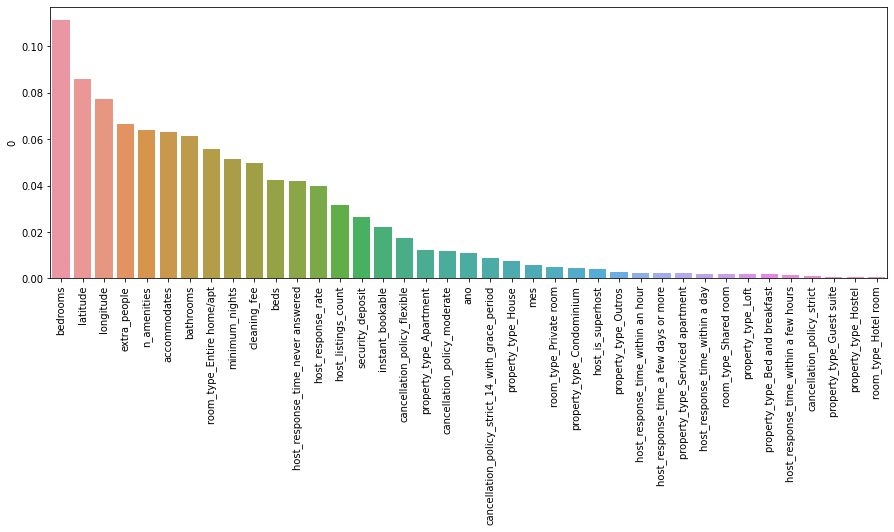

In [107]:
importancia_features_teste = pd.DataFrame(modelo_et.feature_importances_,x_train.columns)
importancia_features_teste = importancia_features_teste.sort_values(by=0, ascending=False)
display(importancia_features_teste)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features_teste.index, y=importancia_features_teste[0])
ax.tick_params(axis='x', rotation=90)

## Deploy do Modelo
- Passo 1 -> Criar arquivo do Modelo (joblib)
- Passo 2 -> Escolhar a forma de deploy:
    - arquivo Executável + Tkinter
    - Deploy em um Microsite (Flask)
    - Deploy apenas para uso direto (Streamlit)
- Passo 3 -> Outro Arquivo Python (pode ser Jupyter ou Pycharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito!

In [109]:
x['price'] = y
x.to_csv('dados.csv')

In [110]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']